# DDPG Main

## Data Preprocessing

In [383]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import gymnasium
from gymnasium import spaces


# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Calculate the 10-period moving average
# df['10_MA'] = df['Last Price'].rolling(window=10).mean()
# df.to_csv('XOM_30_minute_6_month_data.csv', index=False)

# Used for unnormalization
last_price_scaler = MinMaxScaler()
last_price_scaler.fit(df[['Last Price']])
# Normalise data
scaler = MinMaxScaler()
df[['Last Price', 'Volume', 'SMAVG (15)', '10_MA']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)', '10_MA']])


# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print(train_df[10:])

                    Date  Last Price    Volume  SMAVG (15)     10_MA
10   2023-03-08 18:00:00    0.499995  0.043372    0.074594  0.544225
11   2023-03-08 18:30:00    0.521974  0.046837    0.076402  0.535888
12   2023-03-08 19:00:00    0.527885  0.038593    0.075786  0.527086
13   2023-03-08 19:30:00    0.505948  0.067524    0.078888  0.512765
14   2023-03-08 20:00:00    0.492211  0.085734    0.084456  0.499824
...                  ...         ...       ...         ...       ...
1861 2023-10-02 15:00:00    0.755034  0.144825    0.184963  0.865106
1862 2023-10-02 15:30:00    0.762818  0.113712    0.166506  0.851449
1863 2023-10-02 16:00:00    0.764192  0.092697    0.157100  0.838893
1864 2023-10-02 16:30:00    0.761445  0.078738    0.145187  0.827026
1865 2023-10-02 17:00:00    0.771747  0.055809    0.135850  0.818920

[1856 rows x 5 columns]


## Environment

In [384]:
class DDPGTradingEnv(gymnasium.Env):

  def __init__(self, df):
    super().__init__()
    
    self.df = df
    self.current_step = 0
    self.total_steps = 650 #len(df) - 1

    # Negatives mean quantity to sell, 0 is hold, positives mean buy
    self.action_space = spaces.Box(low=-1, high=1, shape=(1, ), dtype=np.float32)
    # Observation space: normalized last price, normalized shares held, normalized cash balance
    self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    self.reset()

  def reset(self):
    self.current_step = 0
    self.total_profit = 0
    self.cash_balance = 10000
    self.max_share_order = 90
    self.shares_held = 0
    self.portfolio_value = self.cash_balance
    self.previous_portfolio_value = self.portfolio_value
    # For plotting
    self.portfolio_history = [np.array([self.portfolio_value], dtype=np.float32)]

    return self.get_observation()

  def get_observation(self):
    current_price = self.df.loc[self.current_step, 'Last Price']
    volume = self.df['Volume'].iloc[self.current_step]
    MA_10 = self.df['10_MA'].iloc[self.current_step]
    return np.array([float(current_price), float(self.shares_held), float(self.cash_balance), float(volume), float(MA_10)])

  def take_action(self, num_shares):
    normalised_current_price = self.df.loc[self.current_step, 'Last Price']
    # Inverse transform to get the un-normalized current price
    current_price = last_price_scaler.inverse_transform([[normalised_current_price]])
    # Checks if we have enough cash to buy
    print("num_shares: ", num_shares)
    print("current_price: ", current_price)
    if num_shares > 0 and self.cash_balance > (num_shares*current_price):
      self.buy_stock(num_shares, current_price)
    # Checks we have enough shares to sell
    elif num_shares < 0 and self.shares_held > -num_shares:
      self.sell_stock(-num_shares, current_price)
    # Update the portfolio value
    self.previous_portfolio_value = self.portfolio_value
    self.portfolio_value = self.cash_balance + (self.shares_held * current_price)

  def buy_stock(self, num_stocks, current_price):
    print("buying")
    self.cash_balance -= (num_stocks * current_price)
    self.shares_held += num_stocks

  def sell_stock(self, num_stocks, current_price):
    print("selling")
    self.cash_balance += (num_stocks * current_price)
    self.shares_held -= num_stocks

  # Action space is one number between -1 and 1.
  def step(self, action):
    print("Shares held: ", self.shares_held)
    print("Cash balance: ", self.cash_balance)
    print("Portfolio value: ", self.portfolio_value)
    self.current_step += 1
    self.take_action(action*self.max_share_order)
    reward = self.calculate_reward()
    terminated = (self.current_step >= self.total_steps)
    observation = self.get_observation()
    info = {'current_step': self.current_step, 'portfolio_value': self.portfolio_value}
    self.portfolio_history.append(self.portfolio_value)
    return observation, reward, terminated, info

  def render(self, mode='human'):
    if mode == 'human':
      print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}")

  # The reward is the change in portfolio value the next time_step
  def calculate_reward(self):
    reward = self.portfolio_value - self.previous_portfolio_value
    return reward

## DDPG Classes

## Actor & Critic Class

In [385]:
# Input: Current state
# Output: Action to be taken
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)).float()
        return x
    
# Input: Current State & Actor's action
# Output: Expected value of state-action pair
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Critic, self).__init__()
        self.fc1_state = nn.Linear(state_dim, 64)
        self.fc2_state = nn.Linear(64, 64)
        self.fc2_action = nn.Linear(action_dim, 64)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x_state = F.relu(self.fc1_state(state))
        x_state = F.relu(self.fc2_state(x_state))

        x_action = F.relu(self.fc2_action(action))

        x = torch.cat((x_state, x_action), dim=0)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## DDPG Class

In [386]:
# Because DDPG is an off-policy actor-critic policy-gradient algorithm, this means that the critic
# evaluates the actor, but because they are off-policy, the agents act according to their own
# policy but learn according to the target policy.

class DDPG:
    def __init__(self, df):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Initialise environment:
        self.env = DDPGTradingEnv(df)
        # Pseudocode line 1:
        # Initialize replay memory 𝐷 to capacity 𝑁
        self.N = 1000
        self.replay_memory = []
        # replay_memory = deque(maxlen=N)
        # Initialise minibatch size
        self.minibatch_size = 50
        # Pseudocode line 2 & 3:
        # Initialize actor network 𝜋̂ 1 with parameters 𝒘1 arbitrarily
        # Initialize target actor network 𝜋̂ 2 with parameters 𝒘2=𝒘1
        self.state_dim = 5
        self.action_dim = 1
        self.actor_model = Actor(self.state_dim, self.action_dim)
        self.target_actor_model = Actor(self.state_dim, self.action_dim)
        # Pseudocode line 4 & 5:
        # Initialize critic network 𝑞̂ 1 with parameters 𝜽1 arbitrarily
        # Initialize target critic network 𝑞̂ 2 with parameters 𝜽2=𝜽1
        self.critic_model = Critic(self.state_dim, self.action_dim)
        self.target_critic_model = Critic(self.state_dim, self.action_dim)

        # Initialise random process ϵ for action exploration
        self.epsilon = 0.5
        # Pseudocode line 6: Algorithm parameters: target network learning rate 𝛽>0
        self.beta = 0.005
        # Gamma is the discount factor (importance of future rewards)
        self.gamma = 0.9
        # This is for the gradient descent
        self.lr = 0.005
        # Optimizers
        self.optimizer_critic = optim.Adam(self.critic_model.parameters(), lr=self.lr)
        self.optimizer_actor = optim.Adam(self.actor_model.parameters(), lr=self.lr)

    # policy
    def select_action(self, state):
        # Select action 𝐴←𝜋̂ 1(𝑆,𝒘1)+
        action = self.actor_model(torch.FloatTensor(state).to(self.device))
        action = action.detach().to('cpu').numpy()
        # print("action: ", action)
        # Add exploration noise (optional). Adds dampened value within action space
        # action += self.epsilon * np.random.randn(self.action_dim)

        # UCOMMENT BELOW TO SEE WHAT I MEAN
        # e - greedy exploration
        if np.random.random() < self.epsilon:
            action = np.array([random.uniform(-1, 1)])

        print("action: ", action)
        
        return action
    
    def store_transition(self, state, action, reward, new_state):
        # Store transition (𝑆,𝐴,𝑅,𝑆′) in 𝐷
        # transition = (state, action, reward, new_state)
        transition = (torch.FloatTensor(state), torch.FloatTensor(action), torch.FloatTensor(reward), torch.FloatTensor(new_state))
        self.replay_memory.append(transition)
    
    # Allows you to perform updates more frequently & helps with regularisation
    def sample_minibatch(self):
        if len(self.replay_memory) <= self.minibatch_size:
            return self.replay_memory
        else:
            return random.sample(self.replay_memory, self.minibatch_size)
        
    def update_critic(self, state, action, reward, new_state):
        # Makes sure state and action are on same device
        state = state.to(self.device)
        action = action.to(self.device)
        new_state_tensor = torch.FloatTensor(new_state).to(self.device)

        # 𝜋̂ 2(𝑆′𝑗,𝒘2)
        target_actor_output = self.target_actor_model(new_state_tensor)
        # y is the TD target value (improved Q-value) for the critic (calculated using actor)
        y = reward + self.gamma * self.target_critic_model(new_state_tensor, target_actor_output)
        
        # Perform gradient descent step ∇𝜽1(𝑦−𝑞̂ 1(𝑆𝑗,𝐴𝑗,𝜽1))2 for critic (critic learning from target critic)
        critic_output = self.critic_model(state, action)
        # critic_loss = F.mse_loss(critic_output, y)
        # y.detach removes tensor
        critic_loss = nn.MSELoss().to(self.device)(critic_output, y.detach())
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
    
    def update_actor(self, state):
        # Perform gradient ascent step ∇𝑤1𝐸[𝑞̂ 1(𝑆𝑗,𝜋̂ 1(𝑆𝑗,𝒘1),𝜽1)] for actor (actor learning from critic)
        actor_output = self.actor_model(state)
        actor_loss = -torch.mean(self.critic_model(state, actor_output))
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

    def update_target_network_parameters(self):
        # Update target actor network parameters 𝒘2←𝛽𝒘1+(1−𝛽)𝒘2
        for target_param, param in zip(self.target_actor_model.parameters(), self.actor_model.parameters()):
            target_param.data.copy_(self.beta * param.data + (1 - self.beta) * target_param.data)    
        # Update target critic network parameters 𝜽2←𝛽𝜽1+(1−𝛽)𝜽2
        for target_param, param in zip(self.target_critic_model.parameters(), self.critic_model.parameters()):
            target_param.data.copy_(self.beta * param.data + (1 - self.beta) * target_param.data)

    def learn(self, state, action, reward, new_state, terminated):
        self.store_transition(state, action, reward, new_state)
        minibatch_sampled_from_D = self.sample_minibatch()
        # For each transition (𝑆𝑗,𝐴𝑗,𝑅𝑗,𝑆′𝑗) in minibatch sampled from 𝐷:
        for transition in minibatch_sampled_from_D:
            # 𝑦←𝑅𝑗+𝛾𝑞̂ 2(𝑆′𝑗,𝜋̂ 2(𝑆′𝑗,𝒘2),𝜽2)
            state, action, reward, new_state = transition
            self.update_critic(state, action, reward, new_state)
            self.update_actor(state)
        self.update_target_network_parameters()


# Loop for each episode:
num_episodes = 1
DDPG_agent = DDPG(df)

for i in range(num_episodes):

    # Initialise S
    state = DDPG_agent.env.reset()

    # Loop for each step of episode (each time step in df)
    terminated = False
    while not terminated:
        
        action = DDPG_agent.select_action(state)
        
        # Execute action 𝐴, observe reward 𝑅 and next-state 𝑆′
        new_state, reward, terminated, info = DDPG_agent.env.step(action)
        
        DDPG_agent.learn(state, action, reward, new_state, terminated)

        # Update state
        state = new_state


action:  [0.57209589]
Shares held:  0
Cash balance:  10000
Portfolio value:  10000
num_shares:  [51.48863014]
current_price:  [[111.4]]
buying
action:  [0.7475112]
Shares held:  [51.48863014]
Cash balance:  [[4264.16660229]]
Portfolio value:  [[10000.]]
num_shares:  [67.27600829]
current_price:  [[111.62]]
action:  [1.]
Shares held:  [51.48863014]
Cash balance:  [[4264.16660229]]
Portfolio value:  [[10011.32749863]]
num_shares:  [90.]
current_price:  [[112.22]]
action:  [1.]
Shares held:  [51.48863014]
Cash balance:  [[4264.16660229]]
Portfolio value:  [[10042.22067672]]
num_shares:  [90.]
current_price:  [[111.65]]
action:  [0.8065748]
Shares held:  [51.48863014]
Cash balance:  [[4264.16660229]]
Portfolio value:  [[10012.87215754]]
num_shares:  [72.59173234]
current_price:  [[110.855]]
action:  [-0.55900769]
Shares held:  [51.48863014]
Cash balance:  [[4264.16660229]]
Portfolio value:  [[9971.93869657]]
num_shares:  [-50.31069203]
current_price:  [[110.6934]]
selling
action:  [0.27173

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.20118799]
Shares held:  [46.96452881]
Cash balance:  [[4809.19060888]]
Portfolio value:  [[9948.04935085]]
num_shares:  [18.10691906]
current_price:  [[109.12]]
buying
action:  [-0.3738703]
Shares held:  [65.07144787]
Cash balance:  [[2833.36360111]]
Portfolio value:  [[9933.95999221]]
num_shares:  [-33.64832703]
current_price:  [[110.]]
selling
action:  [1.]
Shares held:  [31.42312083]
Cash balance:  [[6534.67957491]]
Portfolio value:  [[9991.22286633]]
num_shares:  [90.]
current_price:  [[111.54]]
action:  [-0.88279657]
Shares held:  [31.42312083]
Cash balance:  [[6534.67957491]]
Portfolio value:  [[10039.61447241]]
num_shares:  [-79.45169146]
current_price:  [[111.12]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [31.42312083]
Cash balance:  [[6534.67957491]]
Portfolio value:  [[10026.41676166]]
num_shares:  [90.]
current_price:  [[111.13]]
action:  [1.]
Shares held:  [31.42312083]
Cash balance:  [[6534.67957491]]
Portfolio value:  [[10026.73099287]]
num_shares:  [90.]
current_price:  [[111.22]]
action:  [0.4188732]
Shares held:  [31.42312083]
Cash balance:  [[6534.67957491]]
Portfolio value:  [[10029.55907375]]
num_shares:  [37.6985883]
current_price:  [[110.96]]
buying
action:  [0.81544322]
Shares held:  [69.12170913]
Cash balance:  [[2351.64421739]]
Portfolio value:  [[10021.38906233]]
num_shares:  [73.38988952]
current_price:  [[110.87]]
action:  [0.02882472]
Shares held:  [69.12170913]
Cash balance:  [[2351.64421739]]
Portfolio value:  [[10015.16810851]]
num_shares:  [2.59422489]
current_price:  [[110.61]]
buying
action:  [0.43129344]
Shares held:  [71.71593402]
Cash balance:  [[2064.69700231]]
Portfolio value:  [[9997.19646414]]
num_shares:  [38.81640956]
curre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [71.71593402]
Cash balance:  [[2064.69700231]]
Portfolio value:  [[9982.13611799]]
num_shares:  [90.]
current_price:  [[110.08]]
action:  [1.]
Shares held:  [71.71593402]
Cash balance:  [[2064.69700231]]
Portfolio value:  [[9959.18701911]]
num_shares:  [90.]
current_price:  [[110.21]]
action:  [-0.08475924]
Shares held:  [71.71593402]
Cash balance:  [[2064.69700231]]
Portfolio value:  [[9968.51009053]]
num_shares:  [-7.62833148]
current_price:  [[109.84]]
selling
action:  [1.]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9941.97519494]]
num_shares:  [90.]
current_price:  [[109.48]]
action:  [1.]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9918.90365803]]
num_shares:  [90.]
current_price:  [[109.17]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9899.03650124]]
num_shares:  [90.]
current_price:  [[110.73]]
action:  [-0.9434412]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9999.0131612]]
num_shares:  [-84.90970775]
current_price:  [[109.61]]
action:  [1.]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9927.23504636]]
num_shares:  [90.]
current_price:  [[109.74]]
action:  [1.]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9935.56643469]]
num_shares:  [90.]
current_price:  [[110.39]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9977.22337634]]
num_shares:  [90.]
current_price:  [[109.4]]
action:  [0.47502311]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9913.77664982]]
num_shares:  [42.75208004]
current_price:  [[109.58]]
action:  [-0.59945664]
Shares held:  [64.08760254]
Cash balance:  [[2902.5929321]]
Portfolio value:  [[9925.31241828]]
num_shares:  [-53.95109757]
current_price:  [[108.92]]
selling
action:  [0.29253879]
Shares held:  [10.13650497]
Cash balance:  [[8778.94647901]]
Portfolio value:  [[9883.01460061]]
num_shares:  [26.32849132]
current_price:  [[108.3]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [36.46499629]
Cash balance:  [[5927.57086925]]
Portfolio value:  [[9876.72996752]]
num_shares:  [90.]
current_price:  [[107.85]]
action:  [1.]
Shares held:  [36.46499629]
Cash balance:  [[5927.57086925]]
Portfolio value:  [[9860.32071919]]
num_shares:  [90.]
current_price:  [[107.63]]
action:  [1.]
Shares held:  [36.46499629]
Cash balance:  [[5927.57086925]]
Portfolio value:  [[9852.29842001]]
num_shares:  [90.]
current_price:  [[108.05]]
action:  [-0.22023688]
Shares held:  [36.46499629]
Cash balance:  [[5927.57086925]]
Portfolio value:  [[9867.61371845]]
num_shares:  [-19.82131939]
current_price:  [[107.76]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.74848005]
Shares held:  [16.6436769]
Cash balance:  [[8063.51624642]]
Portfolio value:  [[9857.03886953]]
num_shares:  [-67.36320478]
current_price:  [[107.8]]
action:  [1.]
Shares held:  [16.6436769]
Cash balance:  [[8063.51624642]]
Portfolio value:  [[9857.7046166]]
num_shares:  [90.]
current_price:  [[105.53]]
action:  [1.]
Shares held:  [16.6436769]
Cash balance:  [[8063.51624642]]
Portfolio value:  [[9819.92347003]]
num_shares:  [90.]
current_price:  [[105.74]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [16.6436769]
Cash balance:  [[8063.51624642]]
Portfolio value:  [[9823.41864218]]
num_shares:  [90.]
current_price:  [[107.84]]
action:  [1.]
Shares held:  [16.6436769]
Cash balance:  [[8063.51624642]]
Portfolio value:  [[9858.37036368]]
num_shares:  [90.]
current_price:  [[107.33]]
action:  [0.73843196]
Shares held:  [16.6436769]
Cash balance:  [[8063.51624642]]
Portfolio value:  [[9849.88208846]]
num_shares:  [66.45887611]
current_price:  [[107.36]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [83.10255302]
Cash balance:  [[928.49130691]]
Portfolio value:  [[9850.38139876]]
num_shares:  [90.]
current_price:  [[106.92]]
action:  [1.]
Shares held:  [83.10255302]
Cash balance:  [[928.49130691]]
Portfolio value:  [[9813.81627544]]
num_shares:  [90.]
current_price:  [[106.5]]
action:  [1.]
Shares held:  [83.10255302]
Cash balance:  [[928.49130691]]
Portfolio value:  [[9778.91320317]]
num_shares:  [90.]
current_price:  [[106.36]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.47687303]
Shares held:  [83.10255302]
Cash balance:  [[928.49130691]]
Portfolio value:  [[9767.27884575]]
num_shares:  [42.91857275]
current_price:  [[107.05]]
action:  [1.]
Shares held:  [83.10255302]
Cash balance:  [[928.49130691]]
Portfolio value:  [[9824.61960733]]
num_shares:  [90.]
current_price:  [[107.08]]
action:  [-0.07719368]
Shares held:  [83.10255302]
Cash balance:  [[928.49130691]]
Portfolio value:  [[9827.11268392]]
num_shares:  [-6.94743165]
current_price:  [[106.87]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [76.15512137]
Cash balance:  [[1670.96332712]]
Portfolio value:  [[9809.66114779]]
num_shares:  [90.]
current_price:  [[106.]]
action:  [1.]
Shares held:  [76.15512137]
Cash balance:  [[1670.96332712]]
Portfolio value:  [[9743.4061922]]
num_shares:  [90.]
current_price:  [[106.54]]
action:  [1.]
Shares held:  [76.15512137]
Cash balance:  [[1670.96332712]]
Portfolio value:  [[9784.52995773]]
num_shares:  [90.]
current_price:  [[108.45]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.11524616]
Shares held:  [76.15512137]
Cash balance:  [[1670.96332712]]
Portfolio value:  [[9929.98623955]]
num_shares:  [-10.37215484]
current_price:  [[108.11]]
selling
action:  [0.24509505]
Shares held:  [65.78296653]
Cash balance:  [[2792.2969869]]
Portfolio value:  [[9904.09349828]]
num_shares:  [22.05855411]
current_price:  [[107.935]]
buying
action:  [0.05565455]
Shares held:  [87.84152064]
Cash balance:  [[411.40694883]]
Portfolio value:  [[9892.58147914]]
num_shares:  [5.00890964]
current_price:  [[108.75]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.07693544]
Shares held:  [87.84152064]
Cash balance:  [[411.40694883]]
Portfolio value:  [[9964.17231846]]
num_shares:  [-6.92418937]
current_price:  [[108.6375]]
selling
action:  [1.]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9954.29014739]]
num_shares:  [90.]
current_price:  [[107.74]]
action:  [0.90909396]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9881.66684257]]
num_shares:  [81.81845636]
current_price:  [[107.505]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9862.65126972]]
num_shares:  [90.]
current_price:  [[107.1]]
action:  [0.56273568]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9829.87975056]]
num_shares:  [50.64621164]
current_price:  [[107.21]]
action:  [1.]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9838.780657]]
num_shares:  [90.]
current_price:  [[106.87]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.50203434]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9811.26876436]]
num_shares:  [45.18309023]
current_price:  [[105.94]]
action:  [1.]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9736.01564628]]
num_shares:  [90.]
current_price:  [[106.025]]
action:  [1.]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9742.89361944]]
num_shares:  [90.]
current_price:  [[106.9]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.29114606]
Shares held:  [80.91733127]
Cash balance:  [[1163.63357115]]
Portfolio value:  [[9813.6962843]]
num_shares:  [-26.20314558]
current_price:  [[102.845]]
selling
action:  [1.]
Shares held:  [54.71418569]
Cash balance:  [[3858.49607841]]
Portfolio value:  [[9485.57650599]]
num_shares:  [90.]
current_price:  [[103.24]]
action:  [1.]
Shares held:  [54.71418569]
Cash balance:  [[3858.49607841]]
Portfolio value:  [[9507.18860934]]
num_shares:  [90.]
current_price:  [[102.52]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [54.71418569]
Cash balance:  [[3858.49607841]]
Portfolio value:  [[9467.79439564]]
num_shares:  [90.]
current_price:  [[102.42]]
action:  [1.]
Shares held:  [54.71418569]
Cash balance:  [[3858.49607841]]
Portfolio value:  [[9462.32297707]]
num_shares:  [90.]
current_price:  [[101.37]]
action:  [1.]
Shares held:  [54.71418569]
Cash balance:  [[3858.49607841]]
Portfolio value:  [[9404.87308209]]
num_shares:  [90.]
current_price:  [[100.8286]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.05003364]
Shares held:  [54.71418569]
Cash balance:  [[3858.49607841]]
Portfolio value:  [[9375.25082196]]
num_shares:  [4.50302762]
current_price:  [[100.39]]
buying
action:  [1.]
Shares held:  [59.21721332]
Cash balance:  [[3406.43713541]]
Portfolio value:  [[9351.25318011]]
num_shares:  [90.]
current_price:  [[101.18]]
action:  [1.]
Shares held:  [59.21721332]
Cash balance:  [[3406.43713541]]
Portfolio value:  [[9398.03477863]]
num_shares:  [90.]
current_price:  [[100.94]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.0422505]
Shares held:  [59.21721332]
Cash balance:  [[3406.43713541]]
Portfolio value:  [[9383.82264744]]
num_shares:  [3.80254485]
current_price:  [[101.5611]]
buying
action:  [1.]
Shares held:  [63.01975816]
Cash balance:  [[3020.24649814]]
Portfolio value:  [[9420.60245863]]
num_shares:  [90.]
current_price:  [[101.84]]
action:  [-0.02090528]
Shares held:  [63.01975816]
Cash balance:  [[3020.24649814]]
Portfolio value:  [[9438.17866918]]
num_shares:  [-1.88147559]
current_price:  [[101.42]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.03293914]
Shares held:  [61.13828257]
Cash balance:  [[3211.06575278]]
Portfolio value:  [[9411.71037075]]
num_shares:  [-2.96452271]
current_price:  [[101.65]]
selling
action:  [1.]
Shares held:  [58.17375986]
Cash balance:  [[3512.40948615]]
Portfolio value:  [[9425.77217574]]
num_shares:  [90.]
current_price:  [[100.11]]
action:  [1.]
Shares held:  [58.17375986]
Cash balance:  [[3512.40948615]]
Portfolio value:  [[9336.18458556]]
num_shares:  [90.]
current_price:  [[98.3702]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [58.17375986]
Cash balance:  [[3512.40948615]]
Portfolio value:  [[9234.97387816]]
num_shares:  [90.]
current_price:  [[100.1]]
action:  [0.06586629]
Shares held:  [58.17375986]
Cash balance:  [[3512.40948615]]
Portfolio value:  [[9335.60284796]]
num_shares:  [5.92796585]
current_price:  [[99.8321]]
buying
action:  [-0.30972239]
Shares held:  [64.10172571]
Cash balance:  [[2920.60820659]]
Portfolio value:  [[9320.01809769]]
num_shares:  [-27.87501481]
current_price:  [[99.74]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [36.2267109]
Cash balance:  [[5700.86218349]]
Portfolio value:  [[9314.11432876]]
num_shares:  [90.]
current_price:  [[100.24]]
action:  [1.]
Shares held:  [36.2267109]
Cash balance:  [[5700.86218349]]
Portfolio value:  [[9332.22768421]]
num_shares:  [90.]
current_price:  [[101.17]]
action:  [0.54988078]
Shares held:  [36.2267109]
Cash balance:  [[5700.86218349]]
Portfolio value:  [[9365.91852534]]
num_shares:  [49.48927023]
current_price:  [[101.04]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [85.71598114]
Cash balance:  [[700.46631904]]
Portfolio value:  [[9361.20905293]]
num_shares:  [90.]
current_price:  [[101.14]]
action:  [1.]
Shares held:  [85.71598114]
Cash balance:  [[700.46631904]]
Portfolio value:  [[9369.78065104]]
num_shares:  [90.]
current_price:  [[100.7219]]
action:  [-0.05719643]
Shares held:  [85.71598114]
Cash balance:  [[700.46631904]]
Portfolio value:  [[9333.94279933]]
num_shares:  [-5.14767915]
current_price:  [[100.98]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.12090992]
Shares held:  [80.56830199]
Cash balance:  [[1220.27895945]]
Portfolio value:  [[9356.06609406]]
num_shares:  [-10.88189316]
current_price:  [[101.]]
selling
action:  [1.]
Shares held:  [69.68640882]
Cash balance:  [[2319.35016893]]
Portfolio value:  [[9357.6774601]]
num_shares:  [90.]
current_price:  [[101.02]]
action:  [1.]
Shares held:  [69.68640882]
Cash balance:  [[2319.35016893]]
Portfolio value:  [[9359.07118827]]
num_shares:  [90.]
current_price:  [[100.9]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.87274667]
Shares held:  [69.68640882]
Cash balance:  [[2319.35016893]]
Portfolio value:  [[9350.70881922]]
num_shares:  [78.54720046]
current_price:  [[100.03]]
action:  [1.]
Shares held:  [69.68640882]
Cash balance:  [[2319.35016893]]
Portfolio value:  [[9290.08164354]]
num_shares:  [90.]
current_price:  [[99.65]]
action:  [-0.75244783]
Shares held:  [69.68640882]
Cash balance:  [[2319.35016893]]
Portfolio value:  [[9263.60080819]]
num_shares:  [-67.7203043]
current_price:  [[99.77]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [1.96610452]
Cash balance:  [[9075.80492939]]
Portfolio value:  [[9271.96317725]]
num_shares:  [90.]
current_price:  [[100.14]]
buying
action:  [1.]
Shares held:  [91.96610452]
Cash balance:  [[63.20492939]]
Portfolio value:  [[9272.69063592]]
num_shares:  [90.]
current_price:  [[100.56]]
action:  [1.]
Shares held:  [91.96610452]
Cash balance:  [[63.20492939]]
Portfolio value:  [[9311.31639982]]
num_shares:  [90.]
current_price:  [[100.27]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [91.96610452]
Cash balance:  [[63.20492939]]
Portfolio value:  [[9284.6462295]]
num_shares:  [90.]
current_price:  [[100.]]
action:  [1.]
Shares held:  [91.96610452]
Cash balance:  [[63.20492939]]
Portfolio value:  [[9259.81538128]]
num_shares:  [90.]
current_price:  [[100.13]]
action:  [1.]
Shares held:  [91.96610452]
Cash balance:  [[63.20492939]]
Portfolio value:  [[9271.77097487]]
num_shares:  [90.]
current_price:  [[99.9]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.78745297]
Shares held:  [91.96610452]
Cash balance:  [[63.20492939]]
Portfolio value:  [[9250.61877083]]
num_shares:  [-70.87076727]
current_price:  [[100.03]]
selling
action:  [0.32515689]
Shares held:  [21.09533725]
Cash balance:  [[7152.40777965]]
Portfolio value:  [[9262.57436442]]
num_shares:  [29.26411972]
current_price:  [[99.985]]
buying
action:  [0.13371659]
Shares held:  [50.35945697]
Cash balance:  [[4226.4347694]]
Portfolio value:  [[9261.62507424]]
num_shares:  [12.03449321]
current_price:  [[99.86]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.11839721]
Shares held:  [62.39395018]
Cash balance:  [[3024.67027735]]
Portfolio value:  [[9255.33014212]]
num_shares:  [10.65574869]
current_price:  [[100.615]]
buying
action:  [0.12171852]
Shares held:  [73.04969887]
Cash balance:  [[1952.54212279]]
Portfolio value:  [[9302.43757451]]
num_shares:  [10.95466679]
current_price:  [[100.89]]
buying
action:  [-0.83319922]
Shares held:  [84.00436566]
Cash balance:  [[847.32579024]]
Portfolio value:  [[9322.5262417]]
num_shares:  [-74.98792937]
current_price:  [[100.74]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.32378646]
Shares held:  [9.01643629]
Cash balance:  [[8401.60979478]]
Portfolio value:  [[9309.92558685]]
num_shares:  [-29.14078148]
current_price:  [[101.5]]
action:  [1.]
Shares held:  [9.01643629]
Cash balance:  [[8401.60979478]]
Portfolio value:  [[9316.77807843]]
num_shares:  [90.]
current_price:  [[101.19]]
action:  [0.48891417]
Shares held:  [9.01643629]
Cash balance:  [[8401.60979478]]
Portfolio value:  [[9313.98298318]]
num_shares:  [44.00227538]
current_price:  [[101.15]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [53.01871167]
Cash balance:  [[3950.77964034]]
Portfolio value:  [[9313.62232573]]
num_shares:  [90.]
current_price:  [[101.46]]
action:  [-0.25508448]
Shares held:  [53.01871167]
Cash balance:  [[3950.77964034]]
Portfolio value:  [[9330.05812634]]
num_shares:  [-22.95760315]
current_price:  [[101.74]]
selling
action:  [0.13605766]
Shares held:  [30.06110852]
Cash balance:  [[6286.48618502]]
Portfolio value:  [[9344.90336561]]
num_shares:  [12.24518939]
current_price:  [[102.1232]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9356.4227824]]
num_shares:  [90.]
current_price:  [[102.06]]
action:  [1.]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9353.74902437]]
num_shares:  [90.]
current_price:  [[101.92]]
action:  [1.]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9347.82614266]]
num_shares:  [90.]
current_price:  [[102.08]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9354.59515033]]
num_shares:  [90.]
current_price:  [[102.24]]
action:  [1.]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9361.36415799]]
num_shares:  [90.]
current_price:  [[106.445]]
action:  [-0.82687253]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9539.26214068]]
num_shares:  [-74.4185275]
current_price:  [[105.75]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9509.85926363]]
num_shares:  [90.]
current_price:  [[106.04]]
action:  [1.]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9522.12809002]]
num_shares:  [90.]
current_price:  [[106.03]]
action:  [-0.67265244]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9521.70502705]]
num_shares:  [-60.53871974]
current_price:  [[105.8501]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.53519669]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9514.09412405]]
num_shares:  [48.16770237]
current_price:  [[106.14]]
action:  [0.43738097]
Shares held:  [42.3062979]
Cash balance:  [[5035.96826035]]
Portfolio value:  [[9526.35871981]]
num_shares:  [39.36428749]
current_price:  [[106.23]]
buying
action:  [-0.3293686]
Shares held:  [81.67058539]
Cash balance:  [[854.30000048]]
Portfolio value:  [[9530.16628663]]
num_shares:  [-29.64317406]
current_price:  [[106.67]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9566.1013442]]
num_shares:  [90.]
current_price:  [[106.28]]
action:  [0.64835383]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9545.81065378]]
num_shares:  [58.35184431]
current_price:  [[106.92]]
action:  [1.]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9579.10819703]]
num_shares:  [90.]
current_price:  [[106.87]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.70045832]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9576.50682647]]
num_shares:  [-63.04124893]
current_price:  [[106.97]]
action:  [-0.68540304]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9581.7095676]]
num_shares:  [-61.68627403]
current_price:  [[107.08]]
action:  [-0.80932871]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9587.43258285]]
num_shares:  [-72.83958386]
current_price:  [[106.725]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [1.]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9568.96285182]]
num_shares:  [90.]
current_price:  [[106.37]]
action:  [1.]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9550.4931208]]
num_shares:  [90.]
current_price:  [[107.045]]
action:  [1.]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9585.61162345]]
num_shares:  [90.]
current_price:  [[106.82]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.85391518]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9573.9054559]]
num_shares:  [-76.85236577]
current_price:  [[106.56]]
action:  [1.]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9560.37832895]]
num_shares:  [90.]
current_price:  [[106.47]]
action:  [1.]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9555.69586193]]
num_shares:  [90.]
current_price:  [[106.3269]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [0.69386266]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9548.25073937]]
num_shares:  [62.44763961]
current_price:  [[106.36]]
action:  [-0.65745608]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9549.97284668]]
num_shares:  [-59.17104751]
current_price:  [[106.276]]
action:  [0.19482089]
Shares held:  [52.02741134]
Cash balance:  [[4016.33737709]]
Portfolio value:  [[9545.60254413]]
num_shares:  [17.53387987]
current_price:  [[106.4901]]
buying


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likel

action:  [-0.47909153]
Shares held:  [69.5612912]
Cash balance:  [[2149.15275664]]
Portfolio value:  [[9556.7416129]]
num_shares:  [-43.11823782]
current_price:  [[106.25]]
selling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

ValueError: x and y can be no greater than 2D, but have shapes (650,) and (650, 1, 1)

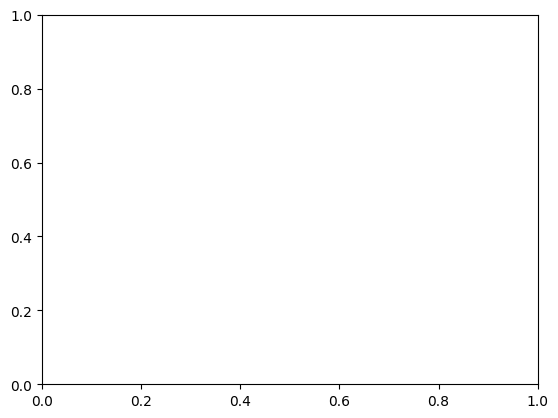

In [ ]:
import matplotlib.pyplot as plt

plt.plot(DDPG_agent.env.portfolio_history[1:])
print(DDPG_agent.env.portfolio_history)
plt.title("Portfolio Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Portfolio value")
plt.show()